In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy import constants as const
from astroquery.simbad import Simbad
from astropy.io import ascii
from astropy.time import Time, TimeDelta
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.optimize import curve_fit


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
column_specs = [ (1, 20), (21, 25), (27, 28), (29, 33), (34, 46), (47, 59), (60, 72), (73, 87), (88, 98), 
                (99, 109), (110, 118), (119, 127), (128, 137), (138, 146), (147, 148), (149, 156), (157, 164), 
                (165, 172), (173, 180), (181, 188), (189, 196), (197, 204), (205, 211), (212, 219), (220, 227),
                (228, 238), (239, 249), (250, 260), (261, 271), (272, 282), (283, 293), (294, 304), (305, 315), 
                (316, 326), (327, 337), (338, 344), (345, 362), (363, 373), (374, 384), (385, 404), (405, 409), 
                (410, 417), (418, 424), (425, 434), (435, 444), (445, 454), (455, 464), (465, 470), (471, 477), 
                (478, 505), (506, 520), (521, 580), (596, 604), (605, 638), (639, 675)]

column_names = ['objID', 'run', 'camcol', 'field', 'RAdeg', 'DEdeg', 'TAIr', 'JD', 'rowV', 'colV', 'e_rowV', 
                'e_colV', 'Vel', 'e_Vel', 'type_r', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'e_umag', 
                'e_gmag', 'e_rmag', 'e_imag', 'e_zmag', 'oRAu', 'oDEu', 'oRAg', 'oDEg', 'oRAr', 'oDEr', 
                'oRAi', 'oDEi', 'oRAz', 'oDEz', 'Number', 'Name', 'RAsdeg', 'DEsdeg', 'DynClass', 'Vmag_sb', 
                'epos', 'centerdist', 'RAbRate', 'DEsbRate', 'Geodist', 'Heliodist', 'alpha', 'elong', 
                'phot_flags', 'R2_Volume', 'p_probs', 'gr_gp_complex', 'proper_params', 'osc_params',]

df = pd.read_fwf('sso.dat', colspecs=column_specs, names=column_names, header=None)

In [4]:
df['gr_gp_complex'].str[0].unique()

array(['C', 'V', 'D', 'S', 'U', 'X', 'B', 'A', 'L', 'K', 'Q'],
      dtype=object)

In [5]:
ok = (np.isfinite(df['e_gmag']) & (df['e_gmag'] < 0.05) & (df['e_gmag'] > 0) &
      np.isfinite(df['e_rmag']) & (df['e_rmag'] < 0.05) & (df['e_rmag'] > 0) &
      np.isfinite(df['e_imag']) & (df['e_imag'] < 0.05) & (df['e_imag'] > 0) &
      np.isfinite(df['e_zmag']) & (df['e_zmag'] < 0.05) & (df['e_zmag'] > 0) & (df['Name'] != '-'))
np.sum(ok)

90893

(-1.0, 1.0)

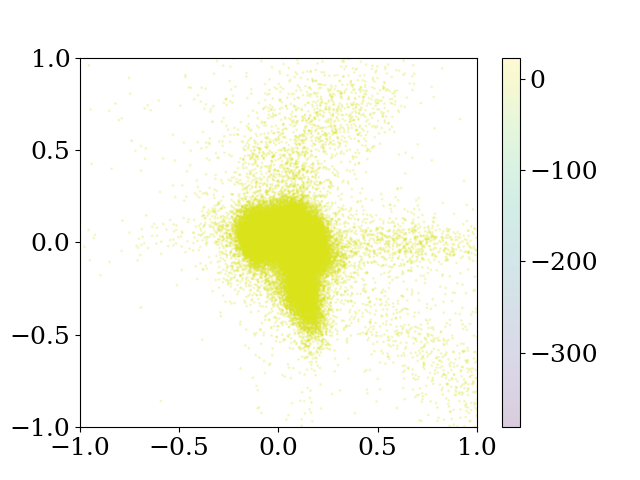

In [6]:
astar = 0.89 * (df['gmag'][ok]-df['rmag'][ok]) + 0.45*(df['rmag'][ok]-df['imag'][ok]) - 0.57

plt.figure()
plt.scatter(astar, df['imag'][ok]-df['zmag'][ok], s=1, alpha=0.2, c=astar**2 / (df['gmag'][ok]-df['imag'][ok]) )
# plt.clim(-1,1)
plt.colorbar()
plt.xlim(-1,1)
plt.ylim(-1,1)
# plt.savefig('test.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

['MB>Outer' '-' 'MB>Inner' 'Trojan' 'MB>Middle' 'MB>Cybele' 'Mars-Crosser'
 'Hungaria' 'MB>Hilda' 'KBO>Resonant>3:2' 'KBO' 'KBO>Resonant>5:4'
 'NEA>Apollo' 'KBO>Classical>Main' 'KBO>Resonant>7:4' 'KBO>Resonant>9:5'
 'NEA>Amor' 'KBO>Resonant>4:3' 'KBO>SDO' 'KBO>Classical>Inner'
 'KBO>Resonant>2:1' 'Centaur' 'Comet' 'KBO>Resonant>5:3'
 'KBO>Resonant>19:9' 'KBO>Resonant>11:6' 'KBO>Resonant>3:1' 'NEA>Aten'
 'KBO>Detached' 'KBO>Resonant>5:2' 'KBO>Resonant>7:2' 'KBO>Resonant>8:3'
 'KBO>Resonant>9:4' 'KBO>Resonant>11:3' 'KBO>Classical>Outer'
 'KBO>Resonant>11:8' 'KBO>Resonant>7:3' 'KBO>Resonant>12:5'
 'KBO>Resonant>11:2']


(-1.0, 1.0)

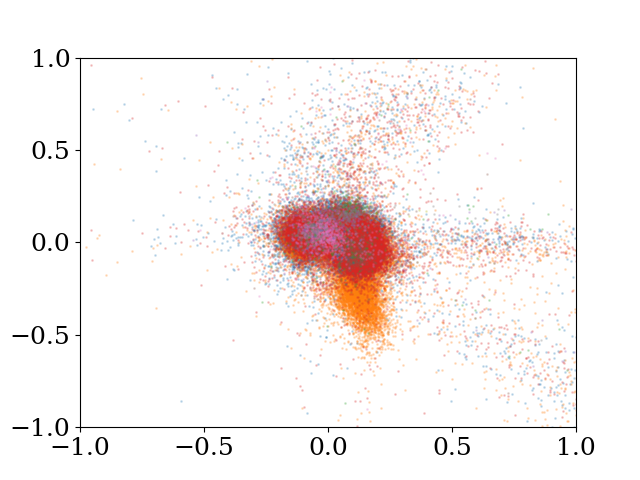

In [7]:
cl = df['DynClass'].unique()
print(cl)
plt.figure()

for k in cl:
    clx = df['DynClass'][ok] == k
    if np.sum(clx) > 0:
        plt.scatter(astar[clx], df['imag'][ok][clx]-df['zmag'][ok][clx], s=1, alpha=0.2)
plt.xlim(-1,1)
plt.ylim(-1,1)
# plt.savefig('test.png', dpi=150, bbox_inches='tight', pad_inches=0.25)   

Text(0, 0.5, 'i-z')

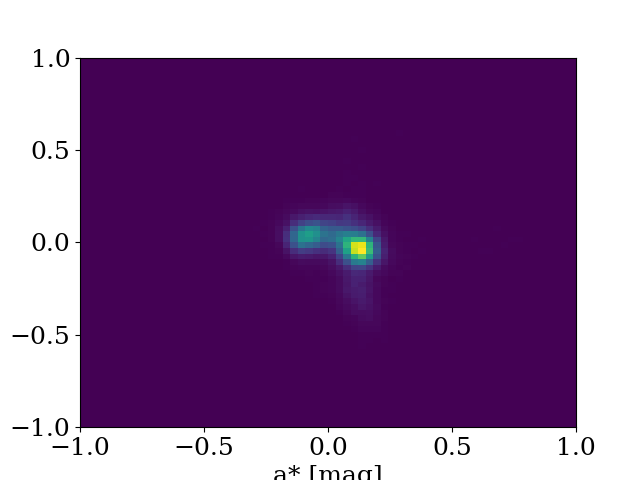

In [8]:
plt.figure()
# plt.scatter(astar, df['imag'][ok]-df['zmag'][ok], s=1, alpha=0.2)
hh, xe, ye, _ = plt.hist2d(astar, df['imag'][ok]-df['zmag'][ok], range=[[-1,1],[-1,1]], bins=66)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('a* [mag]')
plt.ylabel('i-z')


In [9]:
# TESLA data... read from plot
# Ta = 0.22
# Tiz = -0.81

# TESLA data from David Gerdes himself!
tesla = pd.read_csv('Tesla.dat')
# tesla
# did math elsewhere to get these values from this Table...

Tgr, Tgr_err = 0.80, 0.0896
Tri, Tri_err = 0.00, 0.0438
Tiz, Tiz_err = -0.80, 0.0674
Ta, Ta_err = 0.142, 0.0821

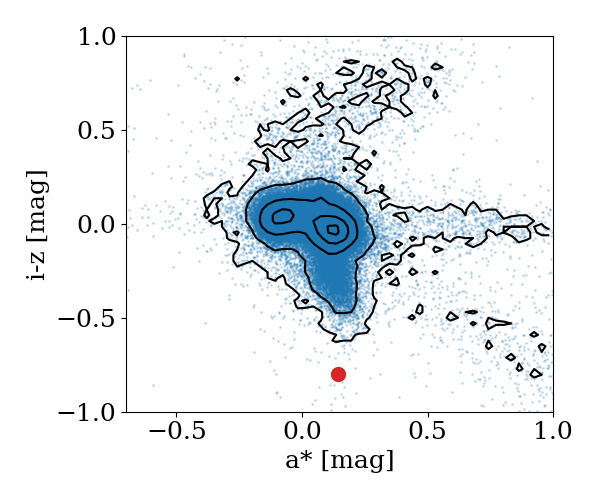

In [10]:
plt.figure(figsize=(6,5))
plt.scatter(astar, df['imag'][ok]-df['zmag'][ok], s=1, alpha=0.2)
plt.contour(hh.T, origin='lower', extent=[xe[0], xe[-1], ye[0], ye[-1]], 
            colors='k', levels=[3,30,300, 1000, 2000,3000])
plt.scatter(Ta,Tiz, s=100, c='C3')
plt.xlim(-0.7,1)
plt.ylim(-1,1)

plt.xlabel('a* [mag]')
plt.ylabel('i-z [mag]')
plt.tight_layout()

In [11]:
from scipy import stats

m1, m2 = astar, df['imag'][ok]-df['zmag'][ok]
xmin = -1
xmax = 1
ymin = -1
ymax = 1

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])

In [12]:
kernel = stats.gaussian_kde(values, bw_method=0.1)
Z = np.reshape(kernel.evaluate(positions).T, X.shape)

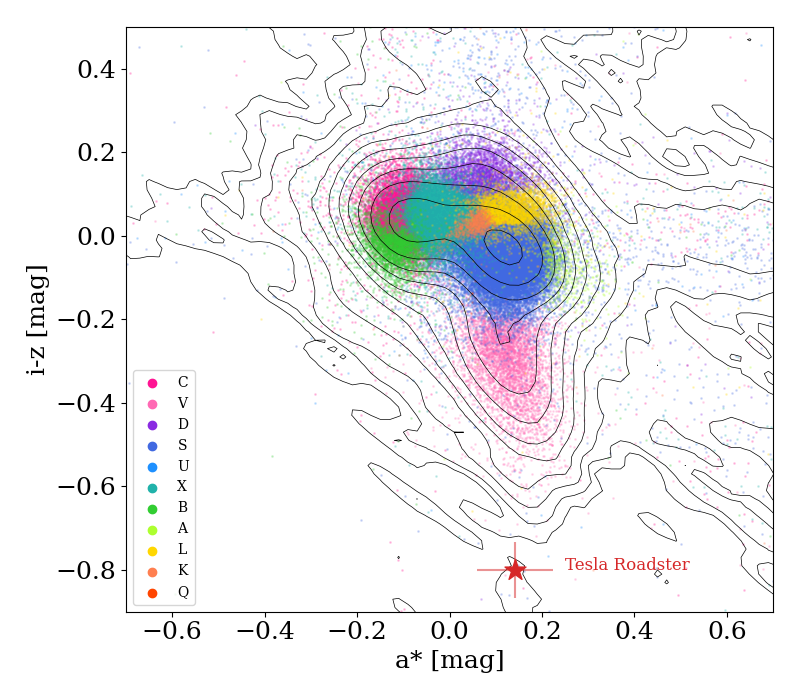

In [23]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)

colors =["#FF1493", "#FF69B4", "#8A2BE2", "#4169E1", "#1E90FF",  "#20B2AA", "#32CD32", "#ADFF2F", "#FFD700", "#FF7F50", "#FF4500"]
cl = df['gr_gp_complex'].str[0].unique()
for k in range(len(cl)):
    clx = df['gr_gp_complex'].str[0][ok] == cl[k]
    if np.sum(clx) > 0:
        plt.scatter([],[],label=cl[k], c=colors[k])
        plt.scatter(astar[clx], df['imag'][ok][clx]-df['zmag'][ok][clx], s=1, alpha=0.2, c=colors[k], rasterized=True)

plt.contour(Z.T, origin='lower', extent=[xmin, xmax, ymin, ymax], 
            levels = np.logspace(-2.3,2.2,15), colors='k', linewidths=0.5)

plt.scatter(Ta,Tiz, s=250, c='C3', zorder=10000, marker='*')#, edgecolors='white')
plt.errorbar(Ta,Tiz, xerr=Ta_err, yerr=Tiz_err, color='C3',alpha=0.5)
plt.text(0.25, -0.8, 'Tesla Roadster', color='C3', fontsize=12)

plt.legend(fontsize=10)
plt.xlim(-0.7,.7)
plt.ylim(-.9,.5)

plt.xlabel('a* [mag]')
plt.ylabel('i-z [mag]')
plt.tight_layout()


In [16]:
# ISO colors in this space:

# 3I/ATLAS from Rubin
iz3 = 18.17 - 18.03
iz3err = np.sqrt(0.011**2 + 0.013**2)

ri3 = 18.37 - 18.13
ri3err = np.sqrt(0.010**2 + 0.010**2)
# don't have g-r from Rubin... argh

atlas_gr, atlas_gr_err = 0.603, 0.031
atlas_ri, atlas_ri_err = 0.210, 0.031
atlas_iz, atlas_iz_err = 0.117, 0.046
atlas_rz, atlas_rz_err = 0.327, 0.035
atlas_astar, atlas_astar_err = 0.06117, 0.03092

# 2I/Borisov, from Bolin
borisov_gr, borisov_gr_err = 0.63, 0.05
borisov_ri, borisov_ri_err = 0.20, 0.05
borisov_gi, borisov_gi_err = 0.83, 0.05
borisov_rz, borisov_rz_err = -0.03, 0.06

# borisov_iz = borisov_rz - borisov_ri
borisov_iz, borisov_iz_err = -0.23, 0.0781

# borisov_astar = 0.89 * (borisov_gr) + 0.45*(borisov_ri) - 0.57
borisov_astar, borisov_astar_err = 0.0807, 0.0499


# 1I/'Oumuamua from meech2017
oumuamua_gr, oumuamua_gr_err = 0.84, 0.05
oumuamua_ri, oumuamua_ri_err = 0.31, 0.09
oumuamua_gi, oumuamua_gi_err = 1.15, 0.10
oumuamua_rz, oumuamua_rz_err = 0.41, 0.10

oumuamua_iz, oumuamua_iz_err = 0.10, 0.1345
oumuamua_astar, oumuamua_astar_err = 0.3171, 0.0602


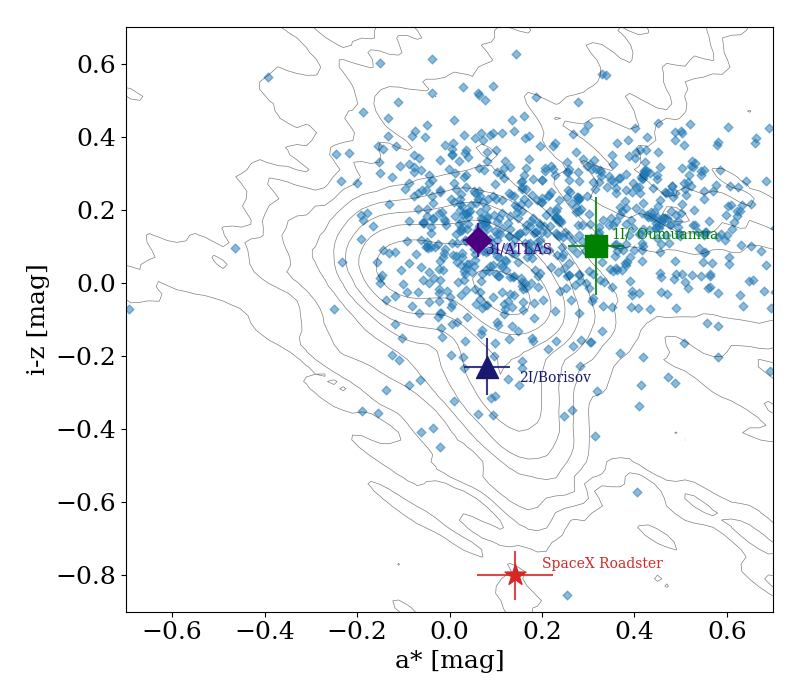

In [39]:
# TNOs from Pedro!
# https://ui.adsabs.harvard.edu/abs/2023ApJS..269...18B/abstract
tno = Table.read('y6_des_tnos_color.fits', format='fits')
# tno.columns
tno_astar = 0.89 * (tno['g-r'].value) + 0.45*(tno['r-i'].value) - 0.57
tno_iz = tno['r-z'].value - tno['r-i'].value

fig = plt.figure(figsize=(8, 7))
plt.scatter(tno_astar, tno_iz, marker='D', s=20, alpha=0.5)
plt.contour(Z.T, origin='lower', extent=[xmin, xmax, ymin, ymax], 
            levels = np.logspace(-2.3,2,11), colors='k', linewidths=0.5, alpha=0.5)

plt.scatter(Ta,Tiz, s=250, c='C3', zorder=10000, marker='*')#, edgecolors='white')
plt.errorbar(Ta,Tiz, xerr=Ta_err, yerr=Tiz_err, color='C3',alpha=0.85)
plt.text(0.2, -0.78, 'SpaceX Roadster', color='C3', fontsize=10)

plt.scatter(borisov_astar, borisov_iz, s=250, c='MidnightBlue', zorder=10000, marker='^')#, edgecolors='white')
plt.errorbar(borisov_astar,borisov_iz, xerr=borisov_astar_err, yerr=borisov_iz_err, color='MidnightBlue',alpha=0.85)
plt.text(0.15, -0.27, '2I/Borisov', color='MidnightBlue', fontsize=10)

plt.scatter(oumuamua_astar, oumuamua_iz, s=250, c='green', zorder=10000, marker='s')#, edgecolors='white')
plt.errorbar(oumuamua_astar,oumuamua_iz, xerr=oumuamua_astar_err, yerr=oumuamua_iz_err, color='green',alpha=0.85)
plt.text(0.35, 0.12, '1I/`Oumuamua', color='green', fontsize=10)

plt.scatter(atlas_astar, atlas_iz, s=175, c='Indigo', zorder=10000, marker='D')#, edgecolors='white')
plt.errorbar(atlas_astar,atlas_iz, xerr=atlas_astar_err, yerr=atlas_iz_err, color='Indigo',alpha=0.85)
plt.text(0.08, 0.08, '3I/ATLAS', color='Indigo', fontsize=10)


plt.xlim(-0.7,.7)
plt.ylim(-.9,.7)

plt.xlabel('a* [mag]')
plt.ylabel('i-z [mag]')
plt.tight_layout()
plt.savefig('tesla-iso-tno-colors.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

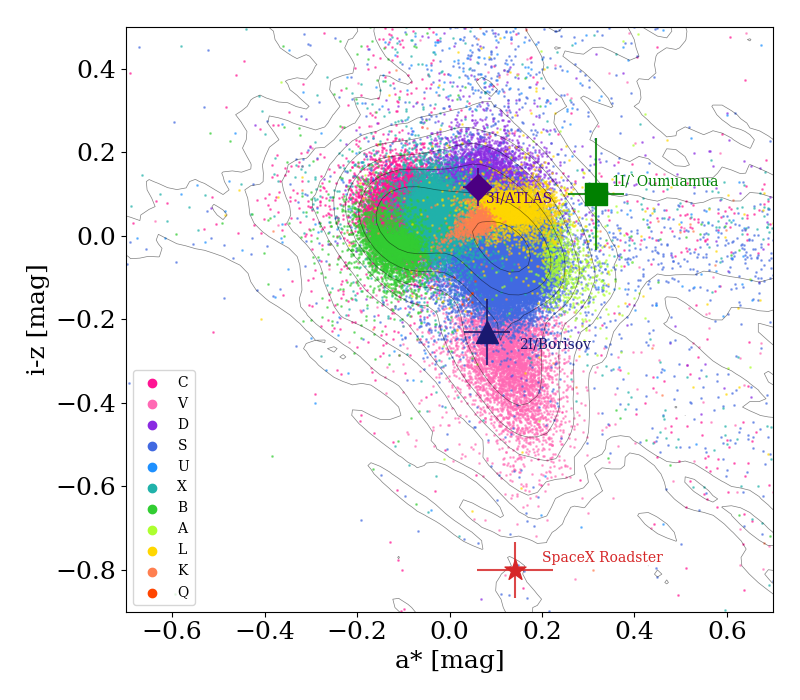

In [31]:
fig = plt.figure(figsize=(8, 7))
# ax = fig.add_subplot(111)

colors =["#FF1493", "#FF69B4", "#8A2BE2", "#4169E1", "#1E90FF",  "#20B2AA", "#32CD32", "#ADFF2F", "#FFD700", "#FF7F50", "#FF4500"]
cl = df['gr_gp_complex'].str[0].unique()
for k in range(len(cl)):
    clx = df['gr_gp_complex'].str[0][ok] == cl[k]
    if np.sum(clx) > 0:
        plt.scatter([],[],label=cl[k], c=colors[k])
        plt.scatter(astar[clx], df['imag'][ok][clx]-df['zmag'][ok][clx], s=1, alpha=0.5, c=colors[k], rasterized=True)

plt.contour(Z.T, origin='lower', extent=[xmin, xmax, ymin, ymax], 
            levels = np.logspace(-2.3,2,11), colors='k', linewidths=0.5, alpha=0.5)

plt.legend(fontsize=10)

plt.scatter(Ta,Tiz, s=250, c='C3', zorder=10000, marker='*')#, edgecolors='white')
plt.errorbar(Ta,Tiz, xerr=Ta_err, yerr=Tiz_err, color='C3',alpha=0.85)
plt.text(0.2, -0.78, 'SpaceX Roadster', color='C3', fontsize=10)

plt.scatter(borisov_astar, borisov_iz, s=250, c='MidnightBlue', zorder=10000, marker='^')#, edgecolors='white')
plt.errorbar(borisov_astar,borisov_iz, xerr=borisov_astar_err, yerr=borisov_iz_err, color='MidnightBlue',alpha=0.85)
plt.text(0.15, -0.27, '2I/Borisov', color='MidnightBlue', fontsize=10)

plt.scatter(oumuamua_astar, oumuamua_iz, s=250, c='green', zorder=10000, marker='s')#, edgecolors='white')
plt.errorbar(oumuamua_astar,oumuamua_iz, xerr=oumuamua_astar_err, yerr=oumuamua_iz_err, color='green',alpha=0.85)
plt.text(0.35, 0.12, '1I/`Oumuamua', color='green', fontsize=10)

plt.scatter(atlas_astar, atlas_iz, s=175, c='Indigo', zorder=10000, marker='D')#, edgecolors='white')
plt.errorbar(atlas_astar,atlas_iz, xerr=atlas_astar_err, yerr=atlas_iz_err, color='Indigo',alpha=0.85)
plt.text(0.08, 0.08, '3I/ATLAS', color='Indigo', fontsize=10)


plt.xlim(-0.7,.7)
plt.ylim(-.9,.5)

plt.xlabel('a* [mag]')
plt.ylabel('i-z [mag]')
plt.tight_layout()
plt.savefig('tesla-iso-colors.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

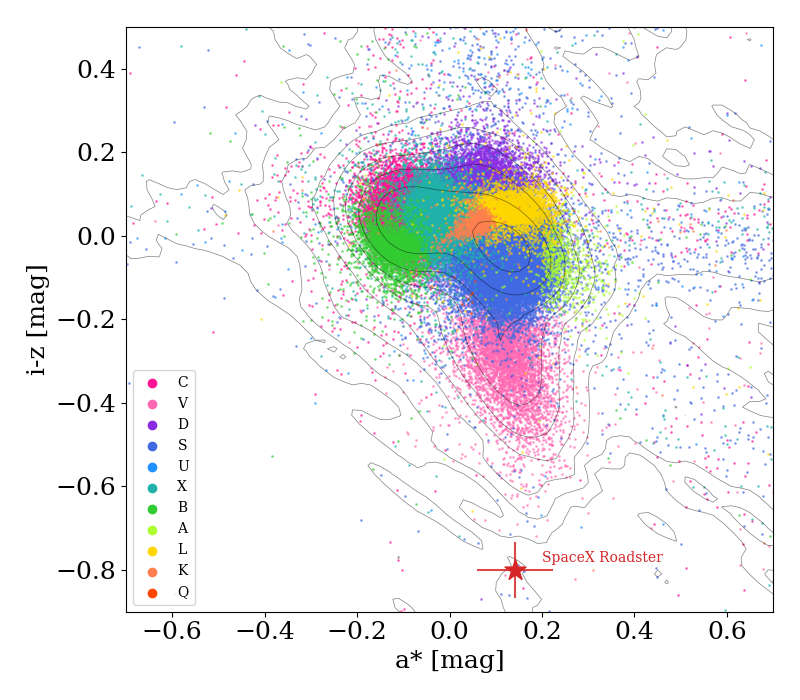

In [22]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)

colors =["#FF1493", "#FF69B4", "#8A2BE2", "#4169E1", "#1E90FF",  "#20B2AA", "#32CD32", "#ADFF2F", "#FFD700", "#FF7F50", "#FF4500"]
cl = df['gr_gp_complex'].str[0].unique()
for k in range(len(cl)):
    clx = df['gr_gp_complex'].str[0][ok] == cl[k]
    if np.sum(clx) > 0:
        plt.scatter([],[],label=cl[k], c=colors[k])
        plt.scatter(astar[clx], df['imag'][ok][clx]-df['zmag'][ok][clx], s=1, alpha=0.5, c=colors[k], rasterized=True)

plt.contour(Z.T, origin='lower', extent=[xmin, xmax, ymin, ymax], 
            levels = np.logspace(-2.3,2,11), colors='k', linewidths=0.5, alpha=0.5)

plt.legend(fontsize=10)

plt.scatter(Ta,Tiz, s=250, c='C3', zorder=10000, marker='*')#, edgecolors='white')
plt.errorbar(Ta,Tiz, xerr=Ta_err, yerr=Tiz_err, color='C3',alpha=0.85)
plt.text(0.2, -0.78, 'SpaceX Roadster', color='C3', fontsize=10)

# plt.scatter(borisov_astar, borisov_iz, s=250, c='MidnightBlue', zorder=10000, marker='^')#, edgecolors='white')
# plt.errorbar(borisov_astar,borisov_iz, xerr=borisov_astar_err, yerr=borisov_iz_err, color='MidnightBlue',alpha=0.85)
# plt.text(0.15, -0.27, '2I/Borisov', color='MidnightBlue', fontsize=10)

# plt.scatter(oumuamua_astar, oumuamua_iz, s=250, c='green', zorder=10000, marker='s')#, edgecolors='white')
# plt.errorbar(oumuamua_astar,oumuamua_iz, xerr=oumuamua_astar_err, yerr=oumuamua_iz_err, color='green',alpha=0.85)
# plt.text(0.35, 0.12, '1I/`Oumuamua', color='green', fontsize=10)

# plt.scatter(atlas_astar, atlas_iz, s=175, c='Indigo', zorder=10000, marker='D')#, edgecolors='white')
# plt.errorbar(atlas_astar,atlas_iz, xerr=atlas_astar_err, yerr=atlas_iz_err, color='Indigo',alpha=0.85)
# plt.text(0.08, 0.08, '3I/ATLAS', color='Indigo', fontsize=10)



plt.xlim(-0.7,.7)
plt.ylim(-.9,.5)

plt.xlabel('a* [mag]')
plt.ylabel('i-z [mag]')
plt.tight_layout()
plt.savefig('tesla-colors.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)